# Projeto 11: Rede Neural Convolucional MNIST

## Importação das bibliotecas

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'2.0.1+cu118'

## Base de dados

In [2]:
torch.manual_seed(123)

In [3]:
transform = transforms.ToTensor()

In [4]:
train = datasets.MNIST(root = '.', train = True, download = True, transform=transform)
test = datasets.MNIST(root = '.', train = False, download = True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 197435220.25it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119463208.90it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 101293154.21it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19499005.90it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
train.data[0] # uma imagem

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [6]:
train.data.shape

torch.Size([60000, 28, 28])

In [7]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

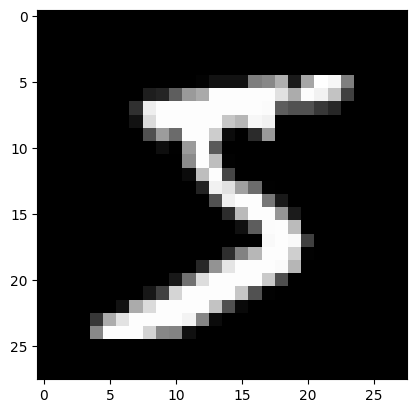

In [9]:
imagem = next(iter(train_loader))[0][0].view(28, 28)
plt.imshow(imagem, cmap='gray');

In [10]:
imagem.shape

torch.Size([28, 28])

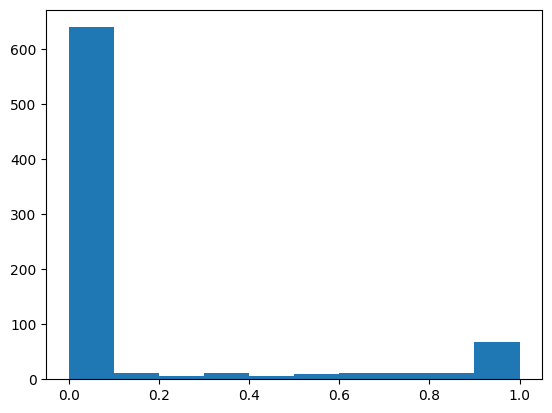

In [11]:
plt.hist(imagem.view(-1));

## Construção do modelo

In [18]:
class classificador(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (3,3))
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features = 32)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))

    self.flatten = nn.Flatten()


    #output = (input - filter + 1) / stride
    #conv1 :(28 - 3 + 1) / 1 = 26x26
    #pool1 :(13x13)
    #conv2 :(13 - 3 + 1) / 1 = 11x11
    #pool2 :(5x5)
    #dense :(32*5*5) = 800 neurons
    self.linear1 = nn.Linear(in_features = 32*5*5, out_features = 128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X



In [19]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Treinamento do modelo

In [20]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [21]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [24]:
def training_loop(loader, epoch):
  running_loss = 0.0
  running_accuracy = 0.0

  for i, data in enumerate(loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    ps = F.softmax(outputs)
    top_p, top_class = ps.topk(k=1, dim=1)
    equals = top_class == labels.view(*top_class.shape)

    accuracy = torch.mean(equals.type(torch.float))
    running_accuracy += accuracy

    print('\rEpoch {:3d} - Loop {:3d} de {:3d}: perda {:.5f}'.format(epoch + 1,
                                                                       i + 1,
                                                                       len(loader),
                                                                       loss,
                                                                       accuracy,
                                                                       end = '\r'))

  print('\rEpoch {:3d} Finalizada: perda {:.5f} - precisao {:.5f}'.format(epoch + 1,
                                                                          running_loss/len(loader),
                                                                          running_accuracy/len(loader)))

In [25]:
for epoch in range(5):
  print('[INFO] Treinando...')
  training_loop(train_loader, epoch)
  net.eval()
  print('[INFO] Validando...')
  training_loop(test_loader, epoch) #testamos
  net.train() #modo treinamento


[INFO] Treinando...
Epoch   1 - Loop   1 de 469: perda 0.01373
Epoch   1 - Loop   2 de 469: perda 0.01374
Epoch   1 - Loop   3 de 469: perda 0.00025
Epoch   1 - Loop   4 de 469: perda 0.03519
Epoch   1 - Loop   5 de 469: perda 0.02165
Epoch   1 - Loop   6 de 469: perda 0.00218
Epoch   1 - Loop   7 de 469: perda 0.03328
Epoch   1 - Loop   8 de 469: perda 0.11377
Epoch   1 - Loop   9 de 469: perda 0.00471
Epoch   1 - Loop  10 de 469: perda 0.01849
Epoch   1 - Loop  11 de 469: perda 0.02044


<ipython-input-24-d8cbea9d86a6>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


Epoch   1 - Loop  12 de 469: perda 0.00317
Epoch   1 - Loop  13 de 469: perda 0.01947
Epoch   1 - Loop  14 de 469: perda 0.00875
Epoch   1 - Loop  15 de 469: perda 0.00296
Epoch   1 - Loop  16 de 469: perda 0.03025
Epoch   1 - Loop  17 de 469: perda 0.00298
Epoch   1 - Loop  18 de 469: perda 0.04419
Epoch   1 - Loop  19 de 469: perda 0.04741
Epoch   1 - Loop  20 de 469: perda 0.00137
Epoch   1 - Loop  21 de 469: perda 0.01935
Epoch   1 - Loop  22 de 469: perda 0.03584
Epoch   1 - Loop  23 de 469: perda 0.01842
Epoch   1 - Loop  24 de 469: perda 0.12518
Epoch   1 - Loop  25 de 469: perda 0.00211
Epoch   1 - Loop  26 de 469: perda 0.06159
Epoch   1 - Loop  27 de 469: perda 0.00420
Epoch   1 - Loop  28 de 469: perda 0.04490
Epoch   1 - Loop  29 de 469: perda 0.00406
Epoch   1 - Loop  30 de 469: perda 0.01465
Epoch   1 - Loop  31 de 469: perda 0.00126
Epoch   1 - Loop  32 de 469: perda 0.00717
Epoch   1 - Loop  33 de 469: perda 0.01103
Epoch   1 - Loop  34 de 469: perda 0.03125
Epoch   1 -

## Avaliação do modelo

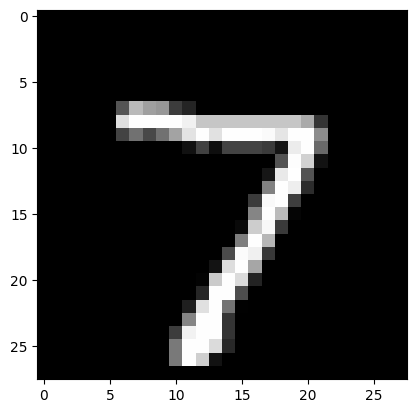

In [29]:
imagem = next(iter(test_loader))[0][0].view(28, 28)
plt.imshow(imagem, cmap='gray');

In [30]:
#(1, 1, 28, 28) = (batch_size, canais de cor, altura, largura)
imagem.shape

torch.Size([28, 28])

In [31]:
imagem = imagem.view(1,1,28,28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [32]:
net.eval()
imagem = imagem.to(device)

In [33]:
previsao = net.forward(imagem)

In [34]:
previsao #logits

tensor([[ -6.7315,  -3.4340,  -3.3574,  -1.4704,  -3.1976,  -8.1294, -15.0425,
          11.6941,  -6.2225,  -1.7039]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [35]:
previsao = F.softmax(previsao) #probabilidades
previsao

<ipython-input-35-9d9eb2fa1dc4>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  previsao = F.softmax(previsao)


tensor([[9.9507e-09, 2.6913e-07, 2.9055e-07, 1.9175e-06, 3.4091e-07, 2.4589e-09,
         2.4458e-12, 1.0000e+00, 1.6555e-08, 1.5182e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [49]:
resultado = np.argmax(previsao)
resultado

7